https://www.tensorflow.org/guide/keras/rnn?hl=ko

https://www.tensorflow.org/tutorials?hl=ko

https://deeptak.tistory.com/8

https://lv99.tistory.com/3

# RNN (Recurrent Neural Net)

<br>

- 시계열 자료, 텍스트 데이터와 같은 시퀀스 데이터를 모델링하는데 아주 좋은 신경망.
- 내부적으로 for loop을 통해 시퀀스의 시간 단계를 반복, 지금까지 본 시간 단계에 대한 정보를 인코딩.
- Keras RNN API
    - 사용 편리성 : 내장 layers.RNN, layers.LSTM, layers.GRU를 통해 빠른 구축이 가능.
    - 사용자 정의 용이성 : 사용자 정의 동작으로 자체 RNN 셀 계층을 만들고, layers.RNN과 같이 사용할 수 있음.

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

**내장 RNN**

<br>

- keras.layers.SimpleRNN : 이전 타임스텝의 출력이 다음 타임스텝으로 연결되는 fully-connected 된 RNN.
- keras.layers.GRU
- keras.layers.LSTM (https://dgkim5360.tistory.com/entry/understanding-long-short-term-memory-lstm-kr)

<br>

다음 예시는 정수 시퀀스를 처리하고, 각 정수를 64차원 벡터에 포함시킨 다음, LSTM 레이어를 통해 벡터 시퀀스를 처리하는 Sequential 모델.

In [3]:
model = keras.Sequential()

model.add(layers.Embedding(input_dim=1000, output_dim=64))

# 128개의 유닛을 가진 LSTM 층 추가
model.add(layers.LSTM(128))
# 출력층 추가
model.add(layers.Dense(10))

model.summary()

NotImplementedError: Cannot convert a symbolic Tensor (lstm/strided_slice:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported

    numpy 1.20 버전일때 나는 에러라고 한다...
    1.19로 다운그레이드 하자.

In [2]:
model = keras.Sequential()

model.add(layers.Embedding(input_dim=1000, output_dim=64))
model.add(layers.LSTM(128))
model.add(layers.Dense(10))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          64000     
_________________________________________________________________
lstm (LSTM)                  (None, 128)               98816     
_________________________________________________________________
dense (Dense)                (None, 10)                1290      
Total params: 164,106
Trainable params: 164,106
Non-trainable params: 0
_________________________________________________________________


    됐다.

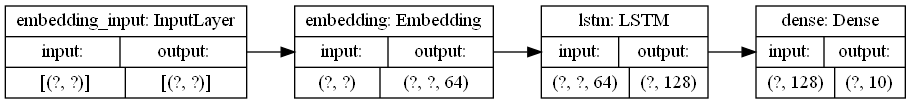

In [3]:
keras.utils.plot_model(model, show_shapes=True, rankdir='LR')

*Embedding Layer가 뭘 할까?*  <br>
- https://heegyukim.medium.com/keras-embedding%EC%9D%80-word2vec%EC%9D%B4-%EC%95%84%EB%8B%88%EB%8B%A4-619bd683ded6
- https://keras.io/api/layers/core_layers/embedding/
- 특정 데이터를 Vector로 바꾸는 층.
    - Vector로 변환하므로 산술 연산이 가능해지고, 머신러닝에 활용이 가능.
- **입력 데이터를 정해진 크기의 벡터로 바꿔 다음 레이어로 전달.**
    - 위 예시는 입력이 64차원의 벡터를 출력하도록 설정했음.
- **Turns positive integers (indexes) into dense vectors of fixed size.**

**RNN Layer, RNN Cell**

<br>

- RNN Cell은 Layer와는 달리 단일 timestamp만 처리함.
- RNN(LSTMCell(10)) == LSTM(10). 동일한 결과를 생성함.
- SimpleRNNCell, GRUCell, LSTMCell 의 3개의 내장 cell이 있음.

## Cross-batch statefulness

<br>

- 매우 긴 시퀀스를 처리할 때, **크로스-배치 상태저장 패턴**을 사용할 수 있음.
    - 보통 RNN 층 내부 상태는 **새로운 배치가 인식될 때 마다 상태가 재설정** 됨.
        - 층에서 볼 수 있는 샘플들은 과거와 독립적인 것으로 가정.
        - 층은 주어진 샘플을 처리하는 동안에만 상태를 유지.
- 시퀀스가 매우 긴 경우, **시퀀스를 더 짧은 시퀀스로 나눈다**.
- 층의 **상태를 재설정 하지 않고**, **짧은 시퀀스를 RNN 층에 순차적으로 공급**.
    - 이렇게 하게 되면 **층이 한번의 1개의 하위 시퀀스만을 받더라도 전체에 대한 정보를 유지**할 수 있다.
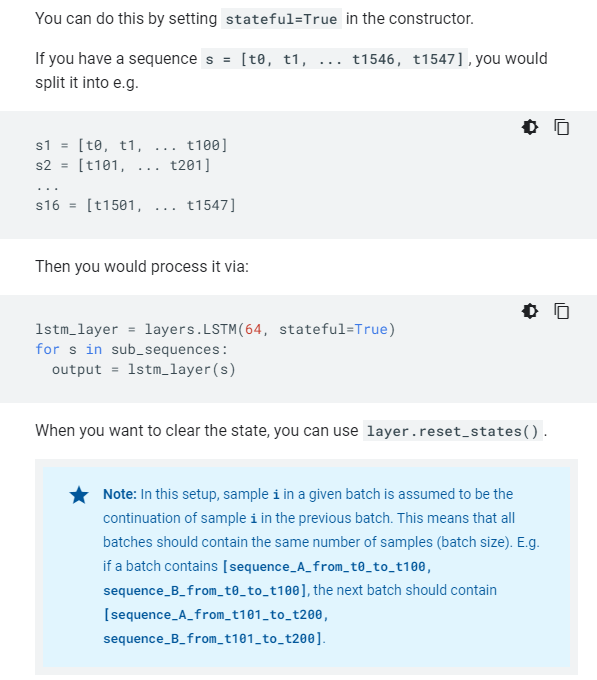

    stateful = True
        한 바퀴(Time step)가 종료된 이후에도 상태를 초기화 하지 않고, 
        다음 바퀴에 초기 상태로 사용.
        
    batch의 sample을 계산한 상태가 다음 batch의 sample을 계산하기 위한 초기상태로 재사용 된다.
    statefulness.
        데이터들 간 상관관계가 있다면 stateful=True로 하고 학습하면 된다는 소리가 아닐까?
        
  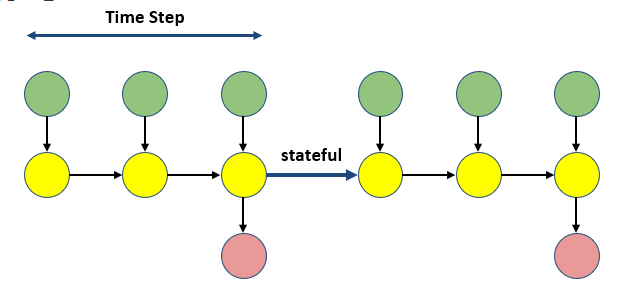

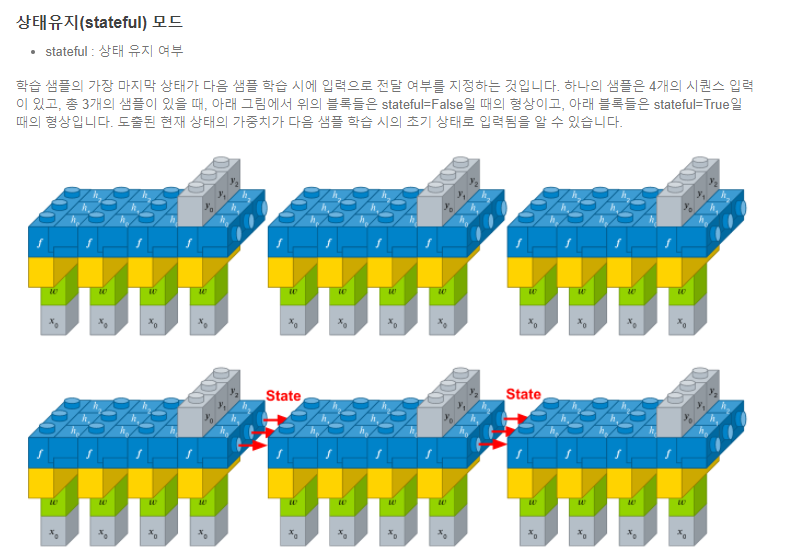

                                        생각한게 맞는듯
  

In [3]:
# 코드를 통해서 한번 보자.
paragraph1 = np.random.random((20, 10, 50)).astype(np.float32)
paragraph2 = np.random.random((20, 10, 50)).astype(np.float32)
paragraph3 = np.random.random((20, 10, 50)).astype(np.float32)

lstm_layer = layers.LSTM(64, stateful=True)
print(lstm_layer.states)
output = lstm_layer(paragraph1)
print(lstm_layer.states)
output = lstm_layer(paragraph2)
print(lstm_layer.states)
output = lstm_layer(paragraph3)
print(lstm_layer.states)

# reset_states()를 통해 초기상태로 되돌릴 수 있음.
# initial_state를 제공하지 않으면, 전부 0으로 초기화 됨.
lstm_layer.reset_states()
print(lstm_layer.states)

[None, None]
[<tf.Variable 'lstm_1/Variable:0' shape=(20, 64) dtype=float32, numpy=
array([[ 0.07196708, -0.2080256 ,  0.03783309, ..., -0.26062375,
         0.1032391 , -0.21682274],
       [ 0.0749854 , -0.2727357 , -0.00091703, ..., -0.3282409 ,
         0.26678294, -0.30267465],
       [ 0.10110906, -0.18395546, -0.00108911, ..., -0.2489673 ,
         0.17844625, -0.23632123],
       ...,
       [ 0.11088823, -0.15954493,  0.00408896, ..., -0.23483625,
         0.21715966, -0.13054483],
       [ 0.1361274 , -0.11926164, -0.02827748, ..., -0.34114537,
         0.14630653, -0.31919426],
       [-0.00365511, -0.08798797,  0.01157357, ..., -0.22705223,
         0.23776425, -0.24762946]], dtype=float32)>, <tf.Variable 'lstm_1/Variable:0' shape=(20, 64) dtype=float32, numpy=
array([[ 0.14099626, -0.46250817,  0.07296032, ..., -0.7332339 ,
         0.22007626, -0.38465562],
       [ 0.1727452 , -0.5396522 , -0.00177389, ..., -0.8421231 ,
         0.605392  , -0.5563378 ],
       [ 0.20111

## 성능 최적화 및 CuDNN Kernel

<br>

- 내장 LSTM 및 GRU 층은 GPU을 사용할 수 있을때 기본적으로 CuDNN 커널을 사용하도록 되어있음.
- 이전 CuDNNLSTM, CuDNNGRU 층은 사용되지 않음.

<br>

**CuDNN 커널?**
- NVDIA에서 제공한 그래픽카드, CUDA 설치해서 같이 쓸수있는거. 예전에 해봤던거 같은데
- 내장 LSTM, GRU 층의 기본값을 변경하게 되면 CuDNN 커널을 사용할 수 없음. 다음과 같은 경우.
    - activation을 tanh에서 다른걸로 변경하는 경우
    - recurrent_activation을 sigmoid에서 다른걸로 변경하는 경우
    - 0보다 큰 recurrent_dropout을 쓰는 경우
    - unroll을 True로 설정한 경우. (내부적으로 있는 while_loop를 for loop로 분해함. 그렇대요)
    - use_bias를 False로 설정한 경우
    - 입력 데이터가 정확히 오른쪽 패딩처리 되어있지 않아 마스킹을 사용하는 경우 (대부분 이 경우라 함)
- 가능한 경우 CuDNN 커널을 쓰는게 속도가 훨~씬 빠르다.

일단 GPU를 쓸 수 있는지 확인을 해보자.

In [14]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 15792432544394128863]

    어라...
    GPU를 쓸려면 그래픽 카드가 있어야 하고,
    그에 맞는 드라이버와 적절한 버전의 CUDA, CuDNN이 설치되어 있어야 한다고 한다.
    
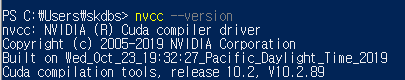

    ??? 있는데??

In [4]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 14409157638938609377, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 12649479316189331961
 physical_device_desc: "device: XLA_CPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 2196032718
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 13995748231605528223
 physical_device_desc: "device: 0, name: GeForce GTX 1060 3GB, pci bus id: 0000:01:00.0, compute capability: 6.1", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 11247870932253633675
 physical_device_desc: "device: XLA_GPU device"]

    OKAYYYYYYYYYYY

CuDDN을 사용했을 때랑, 일반 CPU를 사용했을 때랑 차이를 보자.

In [6]:
# 간단한 LSTM 모델.
# 입력 시퀀스로 MNIST 숫자의 행 시퀀스를 사용, 숫자의 레이블을 예측해보는 예제.

batch_size = 64 # 각 MNIST 이미지의 배치는 (batch_size, 28, 28)의 크기.
input_dim = 28 # 각 input 시퀀스는 (28, 28)이 될것. ??
units = 64
output_size = 10 # 결과 label은 0~9.

# 간단한 RNN 모델을 만들자.
def build_model(allow_cudnn_kernel=True):
    # CuDNN은 층 레벨에서만 사용 가능. Cell 레벨에선 사용 불가.
    # 즉, LSTM(units)는 CuDNN 커널을 사용하고,
    # RNN(LSTMCell(units))는 CuDNN 커널을 사용하지 않는다.
    
    if allow_cudnn_kernel:
        # LSTM 층은 자동으로 CuDNN을 사용할 것.
        lstm_layer = keras.layers.LSTM(units, input_shape=(None, input_dim))
    else:
        # CuDNN을 사용하지 않을 Cell을 정의해 RNN으로 감싼다.
        lstm_layer = keras.layers.RNN(
            keras.layers.LSTMCell(units), input_shape=(None, input_dim)
        )
    model = keras.models.Sequential([
        lstm_layer,
        keras.layers.BatchNormalization(),
        keras.layers.Dense(output_size)
    ])
    return model

In [7]:
# MNIST 데이터 셋을 불러오자.
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
sample, sample_label = x_train[0], y_train[0]

In [8]:
# 모델 훈련 설정마친 후 훈련을 해보자.
model = build_model(allow_cudnn_kernel=True)
model.compile(
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer = 'adam',
    metrics = ['accuracy']
)
model.fit(
    x_train, y_train, validation_data=(x_test, y_test), batch_size=batch_size, epochs=3
)

Epoch 1/3
938/938 [==============================] - 4s 5ms/step - loss: 0.3525 - accuracy: 0.8890 - val_loss: 0.1205 - val_accuracy: 0.9605
Epoch 2/3
938/938 [==============================] - 4s 4ms/step - loss: 0.1132 - accuracy: 0.9653 - val_loss: 0.1144 - val_accuracy: 0.9627
Epoch 3/3
938/938 [==============================] - 4s 4ms/step - loss: 0.0815 - accuracy: 0.9747 - val_loss: 0.0743 - val_accuracy: 0.9770


In [9]:
# CuDNN 커널을 사용하지 않는 모델과 비교해보자.
non_model = build_model(allow_cudnn_kernel=False)
non_model.set_weights(model.get_weights()) # 이건 뭐지 가중치 가져오기? 왜가져오지?
non_model.compile(
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer = 'adam',
    metrics = ['accuracy']
)
non_model.fit(
    x_train, y_train, validation_data=(x_test, y_test), batch_size=batch_size, epochs=3
)

Epoch 1/3
938/938 [==============================] - 42s 44ms/step - loss: 0.0680 - accuracy: 0.9795 - val_loss: 0.0597 - val_accuracy: 0.9802
Epoch 2/3
938/938 [==============================] - 41s 44ms/step - loss: 0.0569 - accuracy: 0.9821 - val_loss: 0.0693 - val_accuracy: 0.9766
Epoch 3/3
938/938 [==============================] - 43s 46ms/step - loss: 0.0485 - accuracy: 0.9848 - val_loss: 0.0593 - val_accuracy: 0.9818


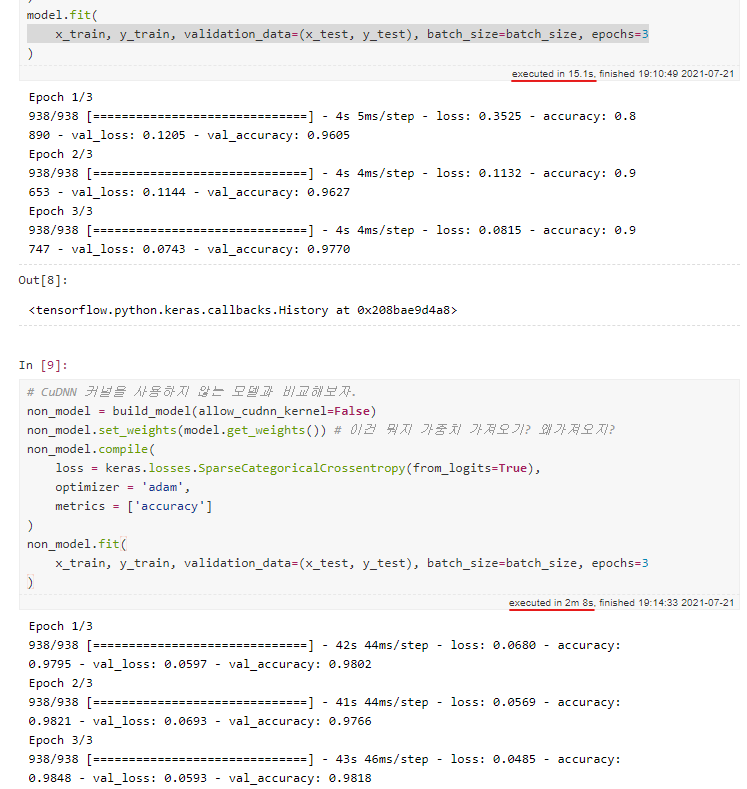

    실화냐... 시간이 거의 8배 차이나네...

    tf.device('CPU:0') 을 써서 강제로 CPU사용을 하게 할 수 있음.
    동일한 CuDNN 모델을 사용, CPU 전용 환경에서 추론을 실행할 수도 있음.

In [ ]:
import matplotlib.pyplot as plt

# CPU 환경에서 실행하도록 설정
with tf.device('CPU:0'):
    cpu_model = build_model(allow_cudnn_kernel=True) # 하지만 모델 빌드는 GPU로.
    cpu_model.set_weights(model.get_weights())
    result = tf.argmax(cpu_model.predict_on_batch(tf.expand_dims(sample, 0)), axis=1)
    print(
        f'예상된 결과는 {result.}'
    )